#### PGE 382 - Numerical Methods in Petroleum and Geosystems Engineering
#### Renato Poli - rep2656

#### CP8 - Apr, 11st

In [1]:
from math import pi, sin, cos, exp
import numpy as np
from numpy import linspace, zeros, arange
from numpy import ix_ as ix
np.set_printoptions(threshold=10000, linewidth=10000)
from numpy import exp, linspace, vectorize
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')

XMAX = 100
YMAX = 25
dx = XMAX/10 ; dy = YMAX/10
Tf = 80 ; Nt=160
dt = Tf/Nt ; Nt = Nt + 1
X = np.arange(0,XMAX+dx,dx) ; Ni = len(X)
Y = np.arange(0,YMAX+dy,dy) ; Nj = len(Y)
Nij = Ni * Nj

beta = .5
Pr = 0.733

# Global index
def _(i,j) : return j + Nj*i

# Calculate F1
def cF1(i, j, U, V, T, Un, Vn, Tn) :
    _ij = _(i,j)
    _0j = _(i-1,j)
    _i0 = _(i,j-1)
    _i1 = _(i,j+1)
 
    ret = 0
    #1 = T
    ret += beta * T[_ij]
    ret += (1-beta) * Tn[_ij]
    #2 = d2U/dy2
    ret += beta * ( U[_i0] - 2*U[_ij] + U[_i1] ) / dy / dy
    ret += (1-beta) * ( Un[_i0] - 2*Un[_ij] + Un[_i1] ) / dy / dy
    #3 = -dU/dt
    ret += Un[_ij]/dt - U[_ij]/dt
    #4 = -U dU/dx
    ret += -beta     * U[_ij]  * ( U[_ij]  - U[_0j] )/dx
    ret += -(1-beta) * Un[_ij] * ( Un[_ij] - Un[_0j] )/dx
    #5 = -V dU/dy
    ret += -beta     * V[_ij]  * ( U[_ij]  - U[_i0])/dy
    ret += -(1-beta) * Vn[_ij] * ( Un[_ij] - Un[_i0])/dy
    return ret

# Calculate F2
def cF2(i, j, U, V, T, Un, Vn, Tn) :
    _ij = _(i,j)
    _0j = _(i-1,j)
    _1j = _(i+1,j)
    _i0 = _(i,j-1)
    _i1 = _(i,j+1)
 
    ret = 0
    #1 = 1/Pr d2T/dy2
    ret += beta * (1/Pr) * ( T[_i0] - 2*T[_ij] + T[_i1] ) / dy / dy
    ret += (1-beta) * (1/Pr) * ( Tn[_i0] - 2*Tn[_ij] + Tn[_i1] ) / dy / dy
    #2 = -dT/dt
    ret += Tn[_ij]/dt - T[_ij]/dt
    #3 = -U dT/dx
    ret += -beta     * U[_ij]  * ( T[_ij]  - T[_0j] )/dx
    ret += -(1-beta) * Un[_ij] * ( Tn[_ij] - Tn[_0j] )/dx
    #4 = -V dT/dy
    ret += -beta     * V[_ij]  * ( T[_ij]  - T[_i0] )/dy
    ret += -(1-beta) * Vn[_ij] * ( Tn[_ij] - Tn[_i0] )/dy
    return ret

# Calculate F3
def cF3(i, j, U, V, T, Un, Vn, Tn) :
    _ij = _(i,j)
    _0j = _(i-1,j)
    _i0 = _(i,j-1)
 
    ret = 0
    #1 = dU/dx
    ret += beta * ( U[_ij] - U[_0j] ) / dx
    ret += (1-beta) * ( Un[_ij] - Un[_0j] ) / dx
    #2 = dV/dy
    ret += beta * ( V[_ij] - V[_i0] ) / dy
    ret += (1-beta) * ( Vn[_ij] - Vn[_i0] ) / dy
    return ret

# The list of free and prescribed dofs
def build_Df() :
    global U_doff, V_doff, T_doff, Ni, Nj

    U_doff=[]
    T_doff=[]
    for i in arange(1,Ni) :
        for j in arange(1,Nj-1) :
            U_doff.append( _(i,j) )
            T_doff.append( _(i,j) )

    V_doff=[]
    for i in arange(1,Ni) :
        for j in arange(1,Nj) :
            V_doff.append( _(i,j) )


#
# Assign BCs to solution vectors
# 
def init_bcs() :
    global Unij, Vnij, Tnij
    Unij = zeros( [Nt,Ni,Nj] )
    Vnij = zeros( [Nt,Ni,Nj] )
    Tnij = zeros( [Nt,Ni,Nj] )

    Unij[0,:,:] = 0 # ic
    Vnij[0,:,:] = 0 # ic
    Tnij[0,:,:] = 0 # ic

    Unij[:,:,0] = 0 # BC , Y=0
    Vnij[:,:,0] = 0 # BC , Y=0
    Tnij[:,:,0] = 1 # BC , Y=0

    Unij[:,:,-1] = 0 # BC , Y=inf
    Tnij[:,:,-1] = 0 # BC , Y=inf

    Unij[:,0,:] = 0 # BC , X=0
    Vnij[:,0,:] = 0 # BC , X=0
    Tnij[:,0,:] = 0 # BC , X=0

#
#
#
#
def build_force() :
    global F1, F2, F3, Ni, Nj, Nij
    # Fx
    F1 = zeros( Nij )
    F2 = zeros( Nij )
    F3 = zeros( Nij )   
    for i in arange(1,Ni) :
        for j in arange(1,Nj-1) :
            _ij = _(i,j)
            F1[_ij] += cF1(i,j,Uk,Vk,Tk,Un,Vn,Tn)
            F2[_ij] += cF2(i,j,Uk,Vk,Tk,Un,Vn,Tn)
    for i in arange(1,Ni) :
        for j in arange(1,Nj) :
            F3[_ij] += cF3(i,j,Uk,Vk,Tk,Un,Vn,Tn)

#
#
#
#
def build_jacobian() :
    global J1U, J1V, J1T, J2U, J2V, J2T, J3U, J3V, J3T

    # DFx/DU 
    J1U = zeros([ Nij, Nij ] )
    J2U = zeros([ Nij, Nij ] )
    J3U = zeros([ Nij, Nij ] )
    # DFx/DV 
    J1V = zeros([ Nij, Nij ] )
    J2V = zeros([ Nij, Nij ] )
    J3V = zeros([ Nij, Nij ] )
    # DFx/DT
    J1T = zeros([ Nij, Nij ] )
    J2T = zeros([ Nij, Nij ] )
    J3T = zeros([ Nij, Nij ] )

    for i in arange(1,Ni) :
        for j in arange(1,Nj-1) :
            _ij = _(i,j)
            _0j = _(i-1,j)
            _1j = _(i+1,j)
            _i0 = _(i,j-1)
            _i1 = _(i,j+1)
        
            # F1
            #               
            #1 = T
            J1T[_ij,_ij] += beta
            #2 = d2U/dy2
            J1U[_ij,_i0] += beta/dy/dy
            J1U[_ij,_ij] += beta*(-2/dy/dy)
            J1U[_ij,_i1] += beta/dy/dy
            #3 = -dU//dt
            J1U[_ij,_ij] += -1/dt 
            #4 = -U dU/dx --
            #            ./dUij = beta*(-2U/dx + U0j/dx)
            #            ./dU0j = beta*U/dx
            J1U[_ij,_ij] += beta * (-2*Uk[_ij] + Uk[_0j])/dx
            J1U[_ij,_0j] += beta * Uk[_ij]/dx
            #5 = -V dU/dy
            #            ./dUij = -beta*V/dy
            #            ./dUj0 = beta*V/dy
            #            ./dVij = -beta*(U-Ui0)/dy
            J1U[_ij,_ij] += -beta * Vk[_ij]/dy
            J1U[_ij,_i0] += beta * Vk[_ij]/dy
            J1V[_ij,_ij] += beta * (-Uk[_ij]+Uk[_i0])/dy

            # F2
            #               
            #1 = 1/Pr d2T/dy2
            J2T[_ij,_ij] += beta * (-2) / Pr / dy / dy
            J2T[_ij,_i0] += beta * 1 / Pr / dy / dy
            J2T[_ij,_i1] += beta * 1 /Pr / dy / dy
            #2 = -dT/dt
            J2T[_ij,_ij] += -1/dt
            #3 = -U dT/dx
            #            (3)/dUij = -beta*(T-T0j)/dx
            #            (3)/dTij = -beta*Uij/dx
            #            (3)/dT0j = beta*Uij/dx
            J2U[_ij,_ij] += -beta * ( Tk[_ij]  - Tk[_0j] )/dx
            J2T[_ij,_ij] += -beta * Uk[_ij] /dx
            J2T[_ij,_0j] += beta * Uk[_ij] /dx
            #4 = -V dT/dy
            #            (4)/dVij = -beta*(T-Ti0)/dy
            #            (4)/dTij = -beta*Uij/dy
            #            (4)/dTi0 = beta*Uij/dy
            J2V[_ij,_ij] += -beta * ( Tk[_ij]  - Tk[_i0] )/dy
            J2T[_ij,_ij] += -beta * Vk[_ij] /dy
            J2T[_ij,_i0] += beta * Vk[_ij] /dy

    for i in arange(1,Ni) :
        for j in arange(1,Nj) :
            _ij = _(i,j)
            _0j = _(i-1,j)
            _1j = _(i+1,j)
            _i0 = _(i,j-1)
            _i1 = _(i,j+1)
            # F3
            #               
            #1 = dU/dx
            J3U[_ij,_ij] += beta/dx
            J3U[_ij,_0j] += -beta/dx
            #2 = dU/dy
            J3V[_ij,_ij] += beta / dy
            J3V[_ij,_i0] += -beta / dy



#
#
#
#
def linear_solve( ) :
    global Nij
    global J1U, J1V, J1T, J2U, J2V, J2T, J3U, J3V, J3T
    global F1, F2, F3
    global JAC, FORCE
    global U_doff, V_doff, T_doff

    JAC = np.block([[ J1U[ix(U_doff,U_doff)], J1V[ix(U_doff,V_doff)], J1T[ix(U_doff,T_doff)]], 
                    [ J2U[ix(T_doff,U_doff)], J2V[ix(T_doff,V_doff)], J2T[ix(T_doff,T_doff)]], 
                    [ J3U[ix(V_doff,U_doff)], J3V[ix(V_doff,V_doff)], J3T[ix(V_doff,T_doff)]] ])
    FORCE = np.block([ F1[ix(U_doff)], F2[ix(T_doff)], F3[ix(V_doff)] ])

    dX = np.linalg.solve( JAC, -FORCE )
    
    # Extract free dofs
    dUk = np.zeros(Nij)
    dVk = np.zeros(Nij)
    dTk = np.zeros(Nij)
    bl1 = len(U_doff) # block length
    bl2 = len(V_doff) # block length
    bl3 = len(T_doff) # block length
    dUk[ix(U_doff)] = dX[:bl1]
    dVk[ix(V_doff)] = dX[bl1:(bl1+bl2)]
    dTk[ix(T_doff)] = dX[(bl1+bl2):]
    
    err = np.linalg.norm(dX)

    return dUk, dVk, dTk, err



#
#
# 
#  MAIN FLOW
#
#
#

# Global solution vector
init_bcs()
build_Df()

for n in arange(1,Nt) :
    print(f"Solving timestep {n} ...")

    # Solution from the previous TS
    Un = Unij[n-1,:,:].flatten()
    Vn = Vnij[n-1,:,:].flatten()
    Tn = Tnij[n-1,:,:].flatten()
    # Initial guess for newton-raphson
    Uk = Un.copy()
    Vk = Vn.copy()
    Tk = Tn.copy()

    nk = 0 #newton loop index
    while(1) :      
        build_jacobian()
        build_force()
        dUk, dVk, dTk, err = linear_solve()

        # Update results
        Uk += dUk
        Vk += dVk
        Tk += dTk

        # Check for convergence
        nk += 1
        print(f"   Newton iteration #{nk} ... (err={err:.3e})")
        if err < 1e-15 : break
        if nk > 50 : break
    
    Unij[n,:,:] = Uk.reshape(Ni,Nj)
    Vnij[n,:,:] = Vk.reshape(Ni,Nj)
    Tnij[n,:,:] = Tk.reshape(Ni,Nj)

Solving timestep 1 ...
   Newton iteration #1 ... (err=3.211e-01)
   Newton iteration #2 ... (err=6.590e-05)
   Newton iteration #3 ... (err=4.760e-11)
   Newton iteration #4 ... (err=1.870e-17)
Solving timestep 2 ...
   Newton iteration #1 ... (err=3.266e-01)
   Newton iteration #2 ... (err=2.126e-04)
   Newton iteration #3 ... (err=6.699e-10)
   Newton iteration #4 ... (err=5.656e-17)
Solving timestep 3 ...
   Newton iteration #1 ... (err=3.633e-01)
   Newton iteration #2 ... (err=3.574e-04)
   Newton iteration #3 ... (err=1.959e-09)
   Newton iteration #4 ... (err=6.386e-17)
Solving timestep 4 ...
   Newton iteration #1 ... (err=4.026e-01)
   Newton iteration #2 ... (err=4.686e-04)
   Newton iteration #3 ... (err=3.389e-09)
   Newton iteration #4 ... (err=8.356e-17)
Solving timestep 5 ...
   Newton iteration #1 ... (err=4.366e-01)
   Newton iteration #2 ... (err=5.306e-04)
   Newton iteration #3 ... (err=4.419e-09)
   Newton iteration #4 ... (err=1.103e-16)
Solving timestep 6 ...
  

C:\Users\rebpo\AppData\Local\Temp\ipykernel_8384\268140633.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = fig.colorbar(pcm, ax=ax1, location='bottom', pad=.07)
C:\Users\rebpo\AppData\Local\Temp\ipykernel_8384\268140633.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb2 = fig.colorbar(pcm, ax=ax2, location='bottom', pad=.07)
C:\Users\rebpo\AppData\Local\Temp\ipykernel_8384\268140633.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb3 = fig.colorbar(pcm, ax=ax3, location='bottom', pad=.07)


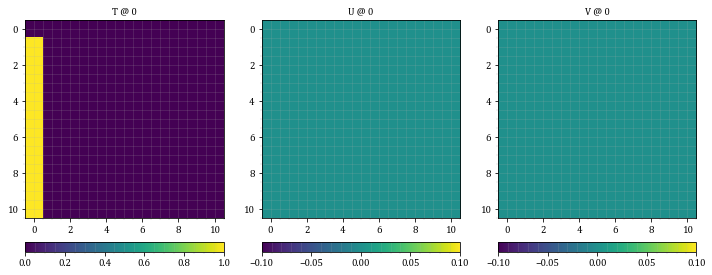

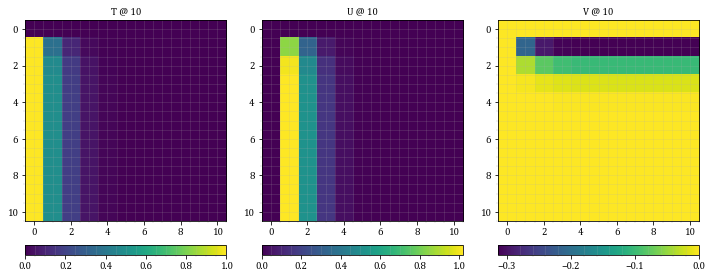

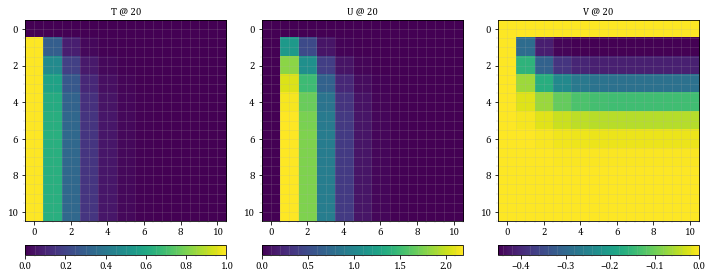

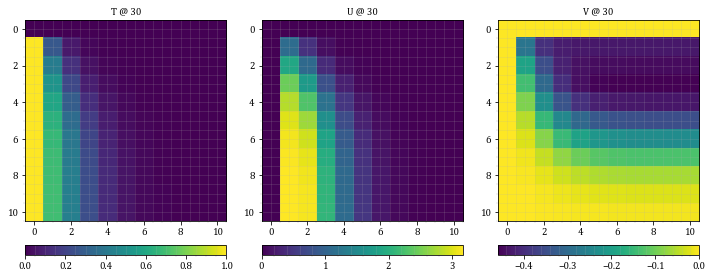

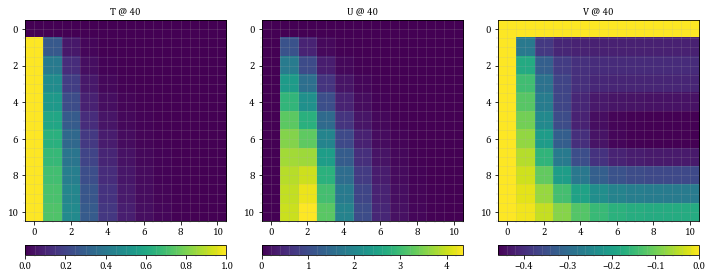

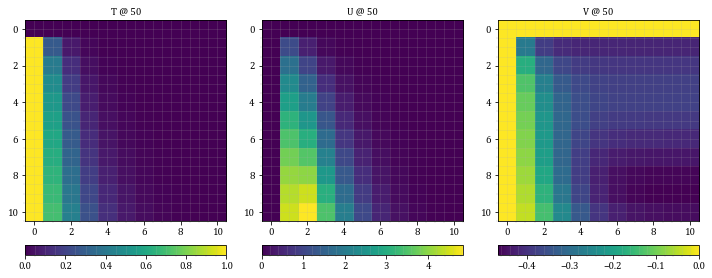

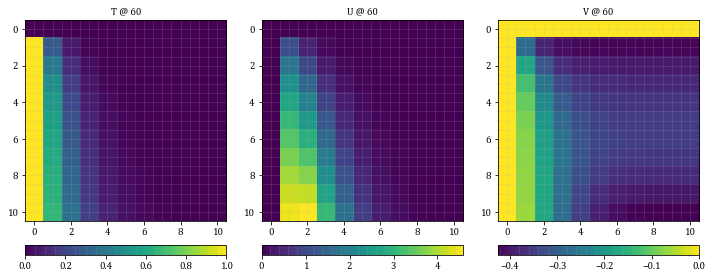

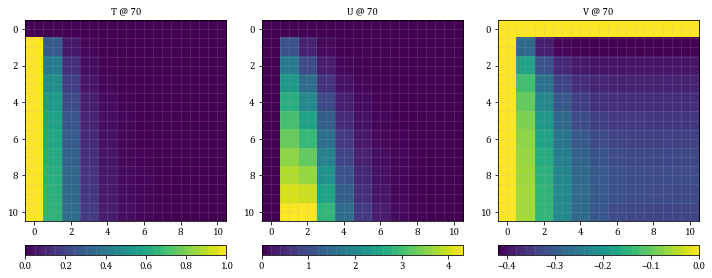

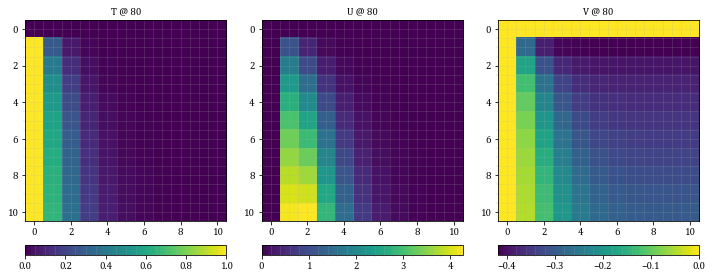

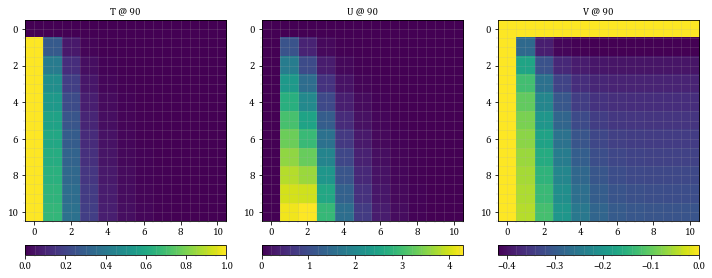

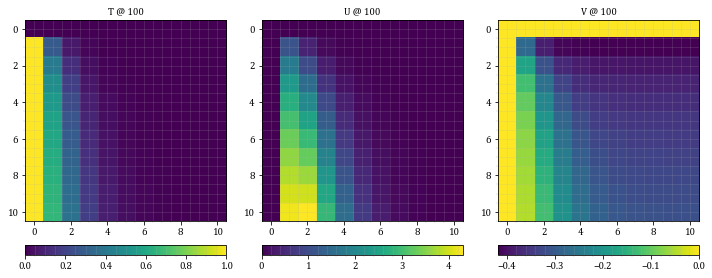

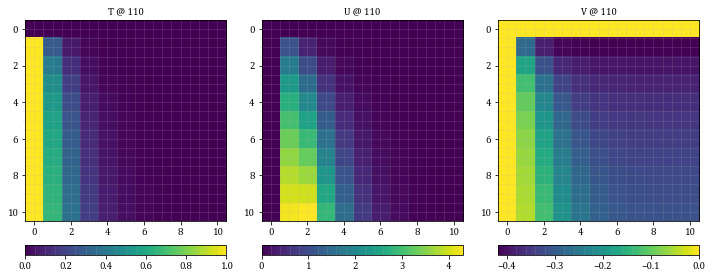

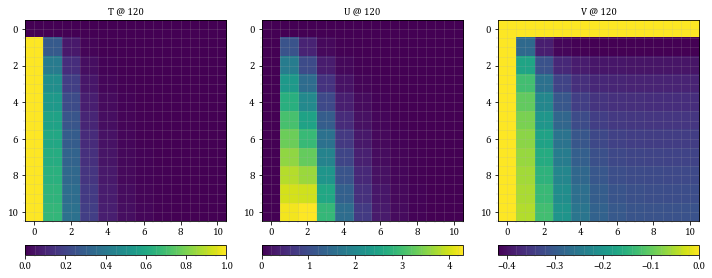

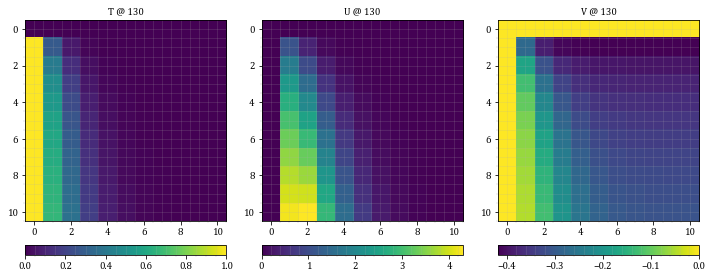

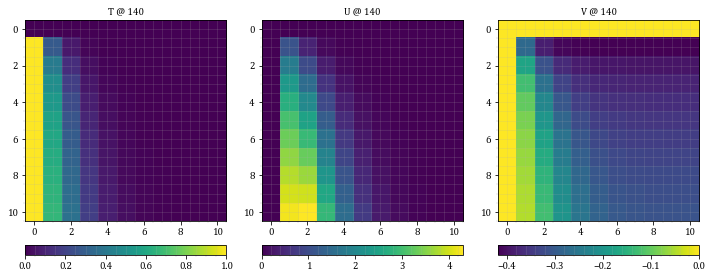

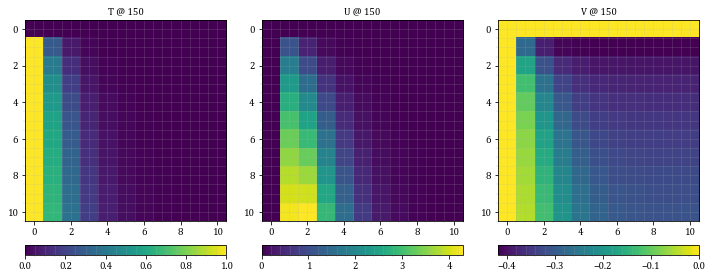

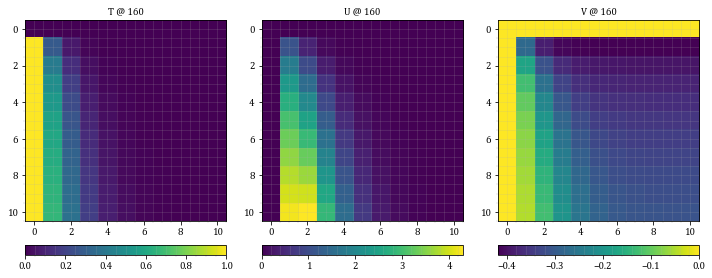

In [2]:
    
#%%
for n in arange(0,Nt,10) :
    fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=[10,5])    
    pcm=ax1.imshow( Tnij[n,:,:] )
    cb1 = fig.colorbar(pcm, ax=ax1, location='bottom', pad=.07)
    pcm=ax2.imshow( Unij[n,:,:] )
    cb2 = fig.colorbar(pcm, ax=ax2, location='bottom', pad=.07)
    pcm=ax3.imshow( Vnij[n,:,:] )
    cb3 = fig.colorbar(pcm, ax=ax3, location='bottom', pad=.07)

    ax1.set_title(f"T @ {n}")
    ax2.set_title(f"U @ {n}")
    ax3.set_title(f"V @ {n}")

    #cb1.mappable.set_clim(1E2,1E9)
    fig.tight_layout()

# EXPLICIT SOLUTION

In [3]:
#%%
from math import pi, sin, cos, exp
import numpy as np
from numpy import linspace, zeros, arange
from numpy import ix_ as ix
np.set_printoptions(threshold=10000, linewidth=10000)
from numpy import exp, linspace, vectorize
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')

XMAX = 100
YMAX = 25
dx = XMAX/10 ; dy = YMAX/10
Tf = 80 ; Nt=160
dt = Tf/Nt ; Nt = Nt + 1
X = np.arange(0,XMAX+dx,dx) ; Ni = len(X)
Y = np.arange(0,YMAX+dy,dy) ; Nj = len(Y)
Nij = Ni * Nj

beta = 0.5
Pr = 0.733

# Global index
def _(i,j) : return j + Nj*i

#
# Assign BCs to solution vectors
# 
def init_bcs() :
    global Unij, Vnij, Tnij
    Unij = zeros( [Nt,Ni,Nj] )
    Vnij = zeros( [Nt,Ni,Nj] )
    Tnij = zeros( [Nt,Ni,Nj] )

    Unij[0,:,:] = 0 # ic
    Vnij[0,:,:] = 0 # ic
    Tnij[0,:,:] = 0 # ic

    Unij[:,:,0] = 0 # BC , Y=0
    Vnij[:,:,0] = 0 # BC , Y=0
    Tnij[:,:,0] = 1 # BC , Y=0

    Unij[:,:,-1] = 0 # BC , Y=inf
    Tnij[:,:,-1] = 0 # BC , Y=inf

    Unij[:,0,:] = 0 # BC , X=0
    Vnij[:,0,:] = 0 # BC , X=0
    Tnij[:,0,:] = 0 # BC , X=0


#
#
# 
#  MAIN FLOW
#
#
#

# Global solution vector
init_bcs()

for n in arange(1,Nt) :
    print(f"Solving timestep {n} ...")

    T = Tnij[n-1,:,:]
    U = Unij[n-1,:,:]
    V = Vnij[n-1,:,:]
    # Solve U
    for i in arange(1,Ni) :
        for j in arange(1,Nj-1) :
            Unij[n,i,j] = U[i,j] + dt * (
                            + T[i,j]                                # T
                            + (U[i,j-1]-2*U[i,j]+U[i,j+1])/dy/dy    # Uyy
                            - U[i,j]*(U[i,j]-U[i-1,j])/dx           # - U Ux
                            - V[i,j]*(U[i,j]-U[i,j-1])/dy           # - U Uy
                        )

    # Solve T
    for i in arange(1,Ni) :
        for j in arange(1,Nj-1) :
            Tnij[n,i,j] = T[i,j] + dt*(
                + 1/Pr*(T[i,j-1]-2*T[i,j]+T[i,j+1])/dy/dy           # Tyy/Pr
                - U[i,j]*(T[i,j]-T[i-1,j])/dx                       # -U Tx
                - V[i,j]*(T[i,j]-T[i,j-1])/dy                       # -V Ty
            )

    # Solve V
    for i in arange(1,Ni) :
        for j in arange(1,Nj) :
            Vnij[n,i,j] = Vnij[n,i,j-1] - dy/dx*( Unij[n,i,j] - Unij[n,i-1,j])



Solving timestep 1 ...
Solving timestep 2 ...
Solving timestep 3 ...
Solving timestep 4 ...
Solving timestep 5 ...
Solving timestep 6 ...
Solving timestep 7 ...
Solving timestep 8 ...
Solving timestep 9 ...
Solving timestep 10 ...
Solving timestep 11 ...
Solving timestep 12 ...
Solving timestep 13 ...
Solving timestep 14 ...
Solving timestep 15 ...
Solving timestep 16 ...
Solving timestep 17 ...
Solving timestep 18 ...
Solving timestep 19 ...
Solving timestep 20 ...
Solving timestep 21 ...
Solving timestep 22 ...
Solving timestep 23 ...
Solving timestep 24 ...
Solving timestep 25 ...
Solving timestep 26 ...
Solving timestep 27 ...
Solving timestep 28 ...
Solving timestep 29 ...
Solving timestep 30 ...
Solving timestep 31 ...
Solving timestep 32 ...
Solving timestep 33 ...
Solving timestep 34 ...
Solving timestep 35 ...
Solving timestep 36 ...
Solving timestep 37 ...
Solving timestep 38 ...
Solving timestep 39 ...
Solving timestep 40 ...
Solving timestep 41 ...
Solving timestep 42 ...
S

C:\Users\rebpo\AppData\Local\Temp\ipykernel_8384\2762846283.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = fig.colorbar(pcm, ax=ax1, location='bottom', pad=.07)
C:\Users\rebpo\AppData\Local\Temp\ipykernel_8384\2762846283.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb2 = fig.colorbar(pcm, ax=ax2, location='bottom', pad=.07)
C:\Users\rebpo\AppData\Local\Temp\ipykernel_8384\2762846283.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb3 = fig.colorbar(pcm, ax=ax3, location='bottom', pad=.07)


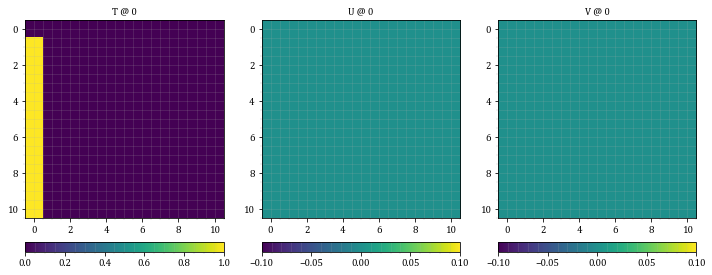

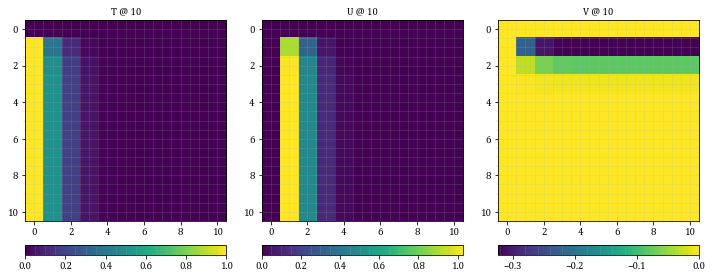

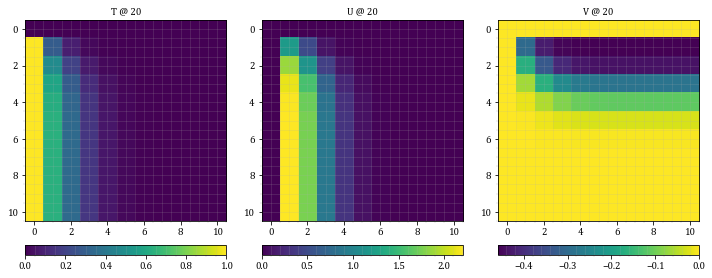

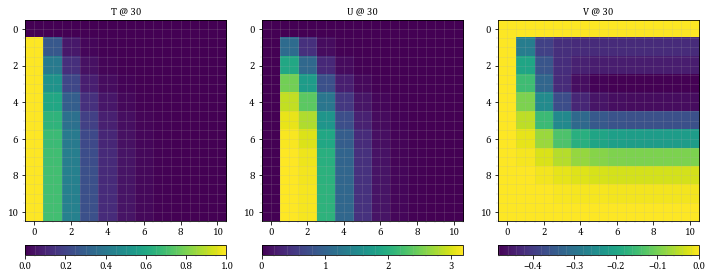

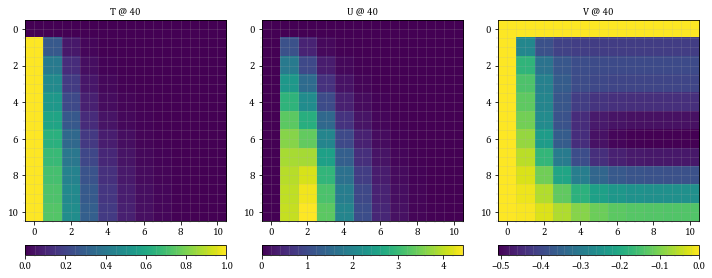

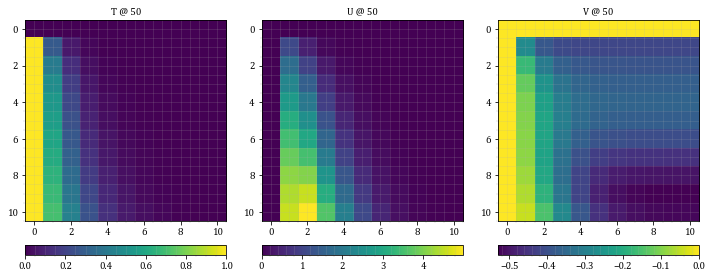

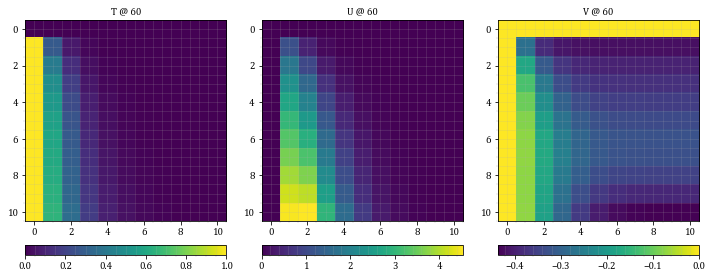

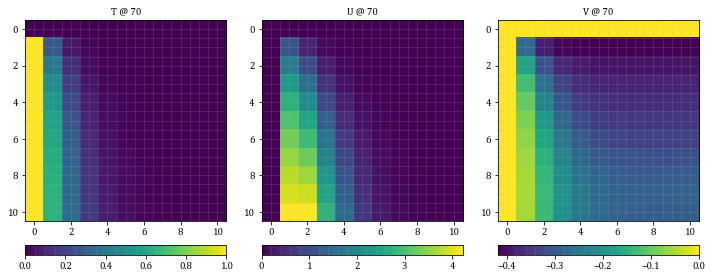

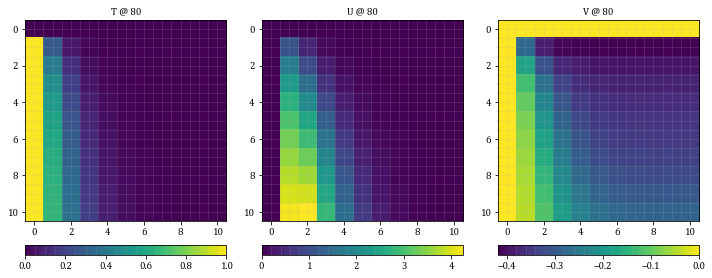

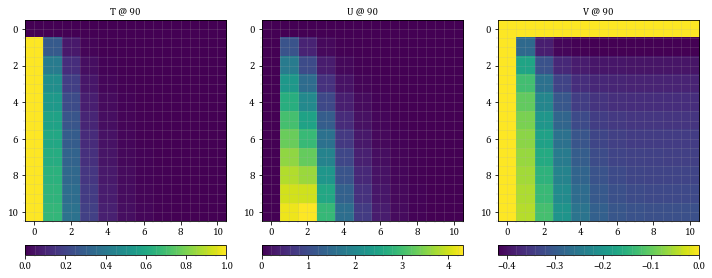

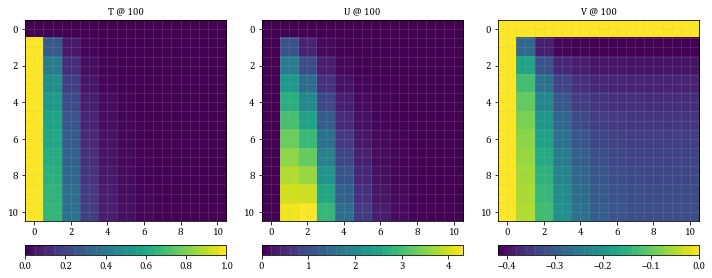

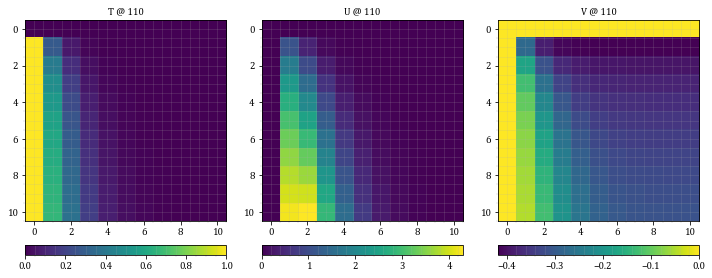

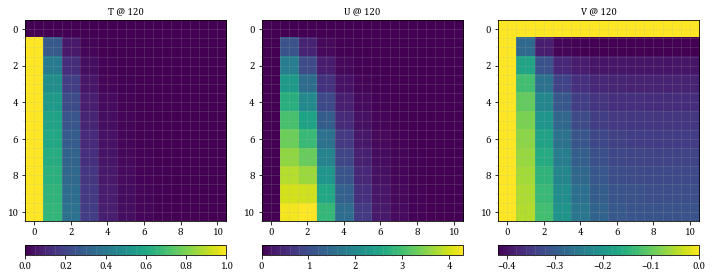

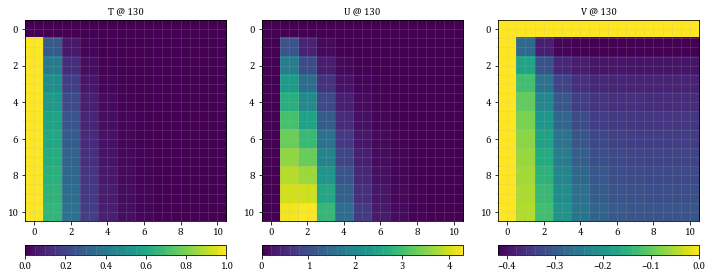

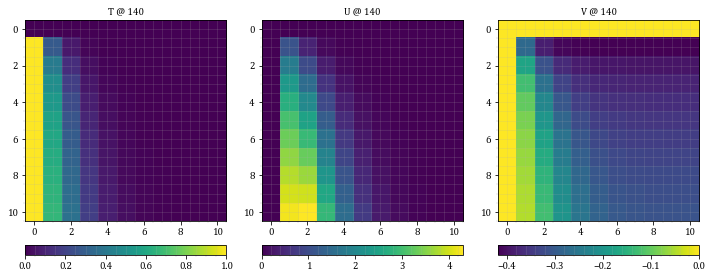

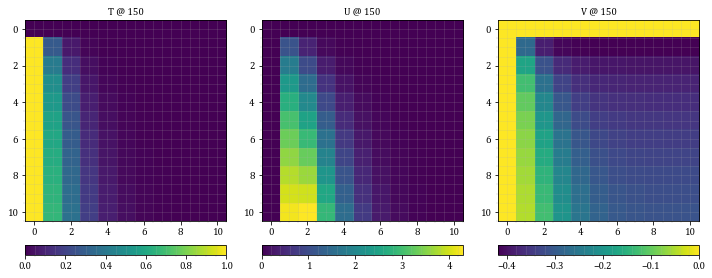

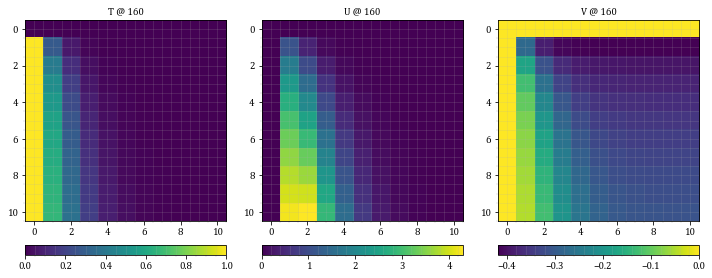

In [4]:
for n in arange(0,Nt,10) :
    fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=[10,5])    
    pcm=ax1.imshow( Tnij[n,:,:] )
    cb1 = fig.colorbar(pcm, ax=ax1, location='bottom', pad=.07)
    pcm=ax2.imshow( Unij[n,:,:] )
    cb2 = fig.colorbar(pcm, ax=ax2, location='bottom', pad=.07)
    pcm=ax3.imshow( Vnij[n,:,:] )
    cb3 = fig.colorbar(pcm, ax=ax3, location='bottom', pad=.07)

    ax1.set_title(f"T @ {n}")
    ax2.set_title(f"U @ {n}")
    ax3.set_title(f"V @ {n}")

    #cb1.mappable.set_clim(1E2,1E9)
    fig.tight_layout()